# Machine Learning for String Field Theory

*H. Erbin, R. Finotello, M. Kudrna, M. Schnabl*

## Abstract

In the framework of bosonic **Open String Field Theory** (OSFT), we consider several observables characterised by conformal weight, periodicity of the oscillations and the position of vacua in the potential for various values of truncated mass level.
We focus on the prediction of the extrapolated value for the level-$\infty$ truncation using Machine Learning (ML) techniques.

## Synopsis

In this notebook we train the machine learning algorithms on the lumps dataset.
We keep observables of `type` $= 2$.

## General Observations

The idea is to improve the finite level predictions and reaching a result as close as possible to the extrapolated label.
In general we can first rescale all the labels to be in the interval $[-1, 1]$ (the lumps should already be in that interval).
We need to find a strategy to evaluate the extrapolated labels with respect to the finite level truncation.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os
import joblib
import time
from IPython.display import Image
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from tensorflow import keras
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from analysis import *

import warnings
warnings.filterwarnings('ignore', message='The objective has been evaluated at this point before.')

# set matplot
sns.set()
PREFIX = 'lumps_'
SUFFIX = '_type2'

# set memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
        
# set random seed
RAND = 42
np.random.seed(RAND)
tf.random.set_seed(RAND)

In [2]:
# create shortcuts for paths
proot = lambda s: os.path.join('.', s)
pdata = lambda s: os.path.join(proot('data'), s)
pimg  = lambda s: os.path.join(proot('img'), s)
pmet  = lambda s: os.path.join(proot('metrics'), s)
pmod  = lambda s: os.path.join(proot('models'), s)

## Load the Dataset

In [3]:
df = pd.read_csv(pdata('lumps.csv'))
df = df.loc[df['type_2'] == 1]
df = df.drop(columns=['type_2', 'type_4'])
last = 'level_18'
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90 entries, 0 to 700
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   solution  90 non-null     int64  
 1   weight    90 non-null     float64
 2   level_2   90 non-null     float64
 3   level_3   90 non-null     float64
 4   level_4   90 non-null     float64
 5   level_5   90 non-null     float64
 6   level_6   90 non-null     float64
 7   level_7   90 non-null     float64
 8   level_8   90 non-null     float64
 9   level_9   90 non-null     float64
 10  level_10  90 non-null     float64
 11  level_11  90 non-null     float64
 12  level_12  90 non-null     float64
 13  level_13  90 non-null     float64
 14  level_14  90 non-null     float64
 15  level_15  90 non-null     float64
 16  level_16  90 non-null     float64
 17  level_17  90 non-null     float64
 18  level_18  90 non-null     float64
 19  exp       90 non-null     float64
dtypes: float64(19), int64(1)
memory u

We need to:

1. define the evaluation metrics,
2. rescale the labels,
3. define the cross-validation strategy,
4. divide into training and test sets,
5. train the algorithms,
6. evaluate each algorithm.

## Evaluation Metric

In general we use the average ratio between the residuals of predicted level and the last finite truncation level:
\begin{equation}
    R(y_{true}, y_{finite}, y_{pred}) = \frac{1}{N} \sum\limits_{i = 1}^N \log_{10}\left| \frac{y_{true}^{(i)} - y_{pred}^{(i)}}{y_{true}^{(i)} - y_{finite}^{(i)}} \right|
\end{equation}
This way a negative result would represent an improvement on finite truncation levels.

## Cross-Validation Strategy

In [4]:
cv = KFold(n_splits=9)

## Train and Test Sets

In [5]:
train, test = train_test_split(df, train_size=0.9, shuffle=True, random_state=RAND)

X_train = train.filter(regex='solution|weight|type.*|level_.*')
X_train.to_csv(pdata(PREFIX + 'X_train' + SUFFIX + '.csv'), index=False)
X_train = X_train.drop(columns=['solution']).values

X_test  = test.filter(regex='solution|weight|type.*|level_.*')
X_test.to_csv(pdata(PREFIX + 'X_test' + SUFFIX + '.csv'), index=False)
X_test = X_test.drop(columns=['solution']).values

y_train = train['exp']
y_train.to_csv(pdata(PREFIX + 'y_train' + SUFFIX + '.csv'), index=False)
y_train = y_train.values.reshape(-1,)

y_test  = test['exp']
y_test.to_csv(pdata(PREFIX + 'y_test' + SUFFIX + '.csv'), index=False)
y_test = y_test.values.reshape(-1,)

In [6]:
print(f'Shape of the training set: X = {X_train.shape}, y = {y_train.shape}')
print(f'Shape of the test     set: X = {X_test.shape},  y = {y_test.shape}')

Shape of the training set: X = (81, 18), y = (81,)
Shape of the test     set: X = (9, 18),  y = (9,)


We also need a validation set (10% of the samples) for the neural networks:

In [7]:
train, validation = train_test_split(train, test_size=1/9, shuffle=False)

X_train_nn = train.filter(regex='solution|weight|type.*|level_.*')
X_train_nn.to_csv(pdata(PREFIX + 'X_train_nn' + SUFFIX + '.csv'), index=False)
X_train_nn = X_train_nn.drop(columns=['solution']).values

X_val_nn  = validation.filter(regex='solution|weight|type.*|level_.*')
X_val_nn.to_csv(pdata(PREFIX + 'X_val_nn' + SUFFIX + '.csv'), index=False)
X_val_nn = X_val_nn.drop(columns=['solution']).values

y_train_nn = train['exp']
y_train_nn.to_csv(pdata(PREFIX + 'y_train_nn' + SUFFIX + '.csv'), index=False)
y_train_nn = y_train_nn.values.reshape(-1,)

y_val_nn  = validation['exp']
y_val_nn.to_csv(pdata(PREFIX + 'y_val_nn' + SUFFIX + '.csv'), index=False)
y_val_nn = y_val_nn.values.reshape(-1,)

y_test_nn = y_test

In [8]:
print(f'Shape of the training   set (ANN): X = {X_train_nn.shape}, y = {y_train_nn.shape}')
print(f'Shape of the validation set (ANN): X = {X_val_nn.shape},  y = {y_val_nn.shape}')

Shape of the training   set (ANN): X = (72, 18), y = (72,)
Shape of the validation set (ANN): X = (9, 18),  y = (9,)


## Extract the Last Truncation Level

In [9]:
last_train    = X_train[:,-1].reshape(-1,)
last_train_nn = X_train_nn[:,-1].reshape(-1,)
last_val_nn   = X_val_nn[:,-1].reshape(-1,)
last_test     = X_test[:,-1].reshape(-1,)
last_test_nn  = X_test[:,-1].reshape(-1,)

## Apply Fourier Transform to Levels

In [10]:
# compute Fourier transform (for real input)
levels_train    = np.fft.rfft(X_train[:,3:], axis=1)
levels_train_nn = np.fft.rfft(X_train_nn[:,3:], axis=1)
levels_val_nn   = np.fft.rfft(X_val_nn[:,3:], axis=1)
levels_test     = np.fft.rfft(X_test[:,3:], axis=1)

# separate modulus and argument
levels_train_mod    = np.abs(levels_train)
levels_train_ang    = np.angle(levels_train) / np.pi
levels_train_nn_mod = np.abs(levels_train_nn)
levels_train_nn_ang = np.angle(levels_train_nn) / np.pi
levels_val_nn_mod   = np.abs(levels_val_nn)
levels_val_nn_ang   = np.angle(levels_val_nn) / np.pi
levels_test_mod     = np.abs(levels_test)
levels_test_ang     = np.angle(levels_test) / np.pi

# concatenate the arrays (the first imaginary part is identically vanishing)
levels_train_conc    = np.c_[levels_train_mod[:,1:], levels_train_ang[:,1:]]
levels_train_nn_conc = np.c_[levels_train_nn_mod[:,1:], levels_train_nn_ang[:,1:]]
levels_val_nn_conc   = np.c_[levels_val_nn_mod[:,1:], levels_val_nn_ang[:,1:]]
levels_test_conc     = np.c_[levels_test_mod[:,1:], levels_test_ang[:,1:]]

In [11]:
# reform the input vectors
X_train    = np.c_[X_train[:,0:3], levels_train_conc]
X_train_nn = np.c_[X_train_nn[:,0:3], levels_train_nn_conc]
X_val_nn   = np.c_[X_val_nn[:,0:3], levels_val_nn_conc]
X_test     = np.c_[X_test[:,0:3], levels_test_conc]

## Rescale the Truncation Levels

In [12]:
lev_scaler    = StandardScaler()
lev_scaler_nn = StandardScaler()

# scale the cross-validation levels
levels_train = lev_scaler.fit_transform(X_train[:,3:])
levels_test  = lev_scaler.transform(X_test[:,3:])

# scale the neural network labels
levels_train_nn = lev_scaler_nn.fit_transform(X_train_nn[:,3:])
levels_val_nn   = lev_scaler_nn.transform(X_val_nn[:,3:])
levels_test_nn  = lev_scaler_nn.transform(X_test[:,3:])

# insert the levels back
X_train[:,3:] = levels_train
X_test[:,3:]  = levels_test

X_train_nn[:,3:] = levels_train_nn
X_val_nn[:,3:]   = levels_val_nn
X_test_nn        = X_test
X_test_nn[:,3:]  = levels_test_nn

In [13]:
os.makedirs('./models', exist_ok=True)

In [14]:
# save the scalers
joblib.dump(lev_scaler, pmod(PREFIX + 'levels_cv_scaler' + SUFFIX + '.pkl'))
joblib.dump(lev_scaler_nn, pmod(PREFIX + 'levels_nn_scaler' + SUFFIX + '.pkl'))

['./models/lumps_levels_nn_scaler_type2.pkl']

## Training

In [15]:
os.makedirs('./img', exist_ok=True)
os.makedirs('./metrics', exist_ok=True)

### Linear Regression (w/ $\ell_2$ regularisation)

In [16]:
spaces    = {'alpha':         Real(1.0e-8, 1.0e-1, prior='log-uniform'),
             'fit_intercept': Integer(0, 1),
             'normalize':     Integer(0, 1)
            }
estimator = BayesSearchCV(Ridge(tol=1.0e-5, random_state=RAND),
                          spaces,
                          n_iter=100,
                          scoring='neg_mean_squared_error',
                          n_jobs=-1,
                          cv=cv,
                          random_state=RAND
                         )         

# fit the estimator
t = time.time()
estimator = estimator.fit(X_train, y_train)
t = time.time() - t
print(f'Optimisation time: {t:.3f} seconds.')

Optimisation time: 113.950 seconds.


In [17]:
best_estimator, cv_score, best_hyperparameters = statisticsCV(estimator, cv)
print(f'CV score: {-cv_score[0]:.3f} ± {cv_score[1]:.3f}')

CV score: 0.008 ± 0.002


In [18]:
# save best estimator
joblib.dump(best_estimator, pmod(PREFIX + 'lr' + SUFFIX + '.pkl'))

['./models/lumps_lr_type2.pkl']

In [19]:
# save the hyperparameters
best_hyperparameters.to_csv(pmet(PREFIX + 'lr_hyperparameters' + SUFFIX + '.csv'))
best_hyperparameters

,ridge
alpha,0.000007
fit_intercept,1.000000
normalize,1.000000


In [20]:
train_metrics = make_predictions(best_estimator, X_train, y_train, last_train, prefix=PREFIX, suffix=SUFFIX, name='train_lr')
test_metrics  = make_predictions(best_estimator, X_test, y_test, last_test, prefix=PREFIX, suffix=SUFFIX, name='test_lr')

# concatenate the prediction results
metrics = pd.concat([train_metrics, test_metrics], axis=0).transpose()
metrics.to_csv(pmet(PREFIX + 'lr_metrics' + SUFFIX + '.csv'))
metrics

,train_lr,test_lr
mean_squared_error,3.005128e-07,0.000003
mean_absolute_error,4.244799e-04,0.001499
r2_score,9.999988e-01,0.999987
residual_ratio,-8.050299e-01,-0.172190


In [21]:
make_plots(estimator, X_train, y_train, last_train, prefix=PREFIX, suffix=SUFFIX, name='train_lr')
make_plots(estimator, X_test, y_test, last_test, prefix=PREFIX, suffix=SUFFIX, name='test_lr')
compare_plots(estimator, X_train, y_train, last_train, X_test, y_test, last_test, legend=['training', 'test'], prefix=PREFIX, suffix=SUFFIX, name='lr')

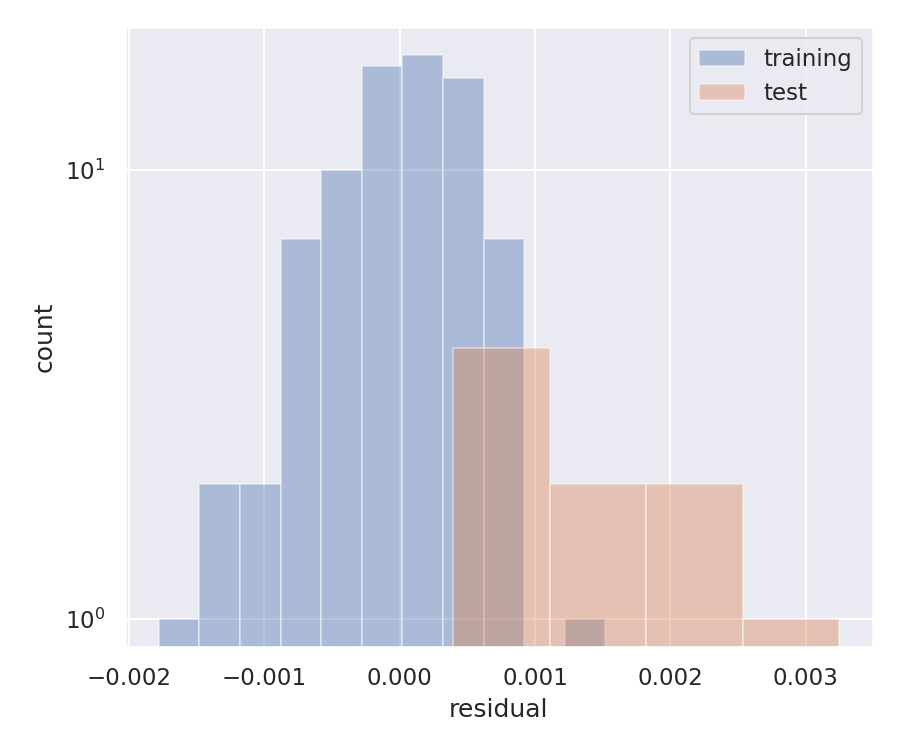

In [22]:
Image(pimg(PREFIX + 'lr_residual_histogram_compare' + SUFFIX + '.png'), width=480)

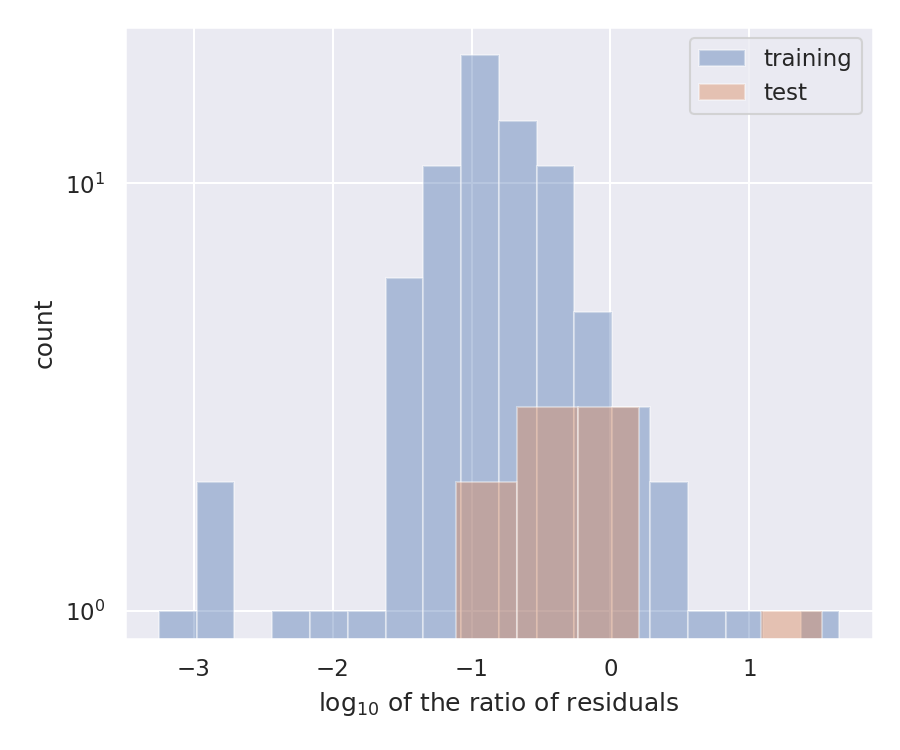

In [23]:
Image(pimg(PREFIX + 'lr_ratio_histogram_compare' + SUFFIX + '.png'), width=480)

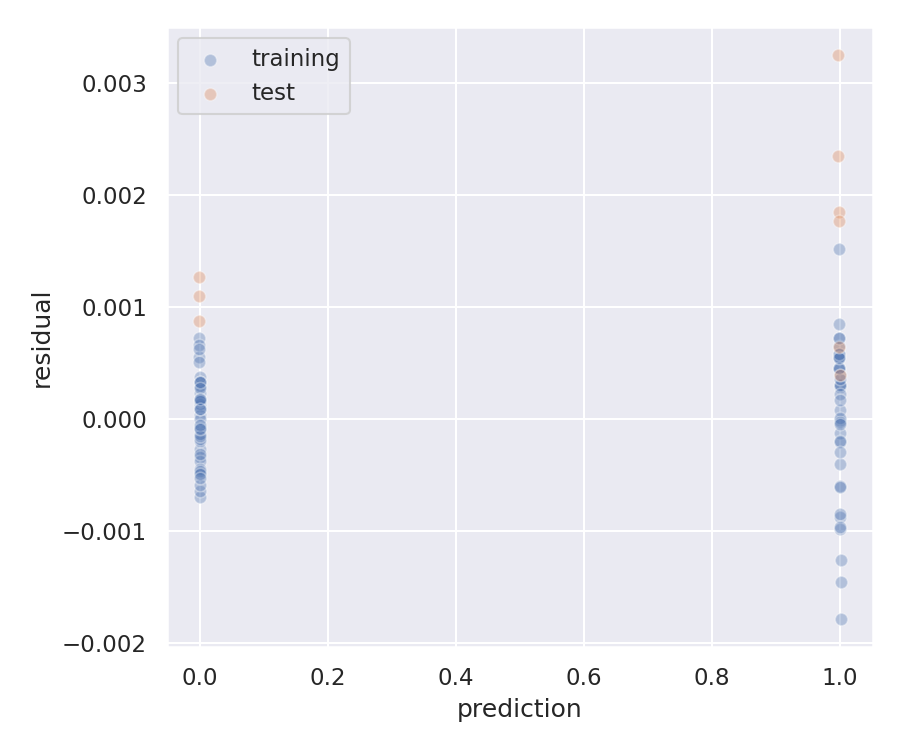

In [24]:
Image(pimg(PREFIX + 'lr_residual_scatterplot_compare' + SUFFIX + '.png'), width=480)

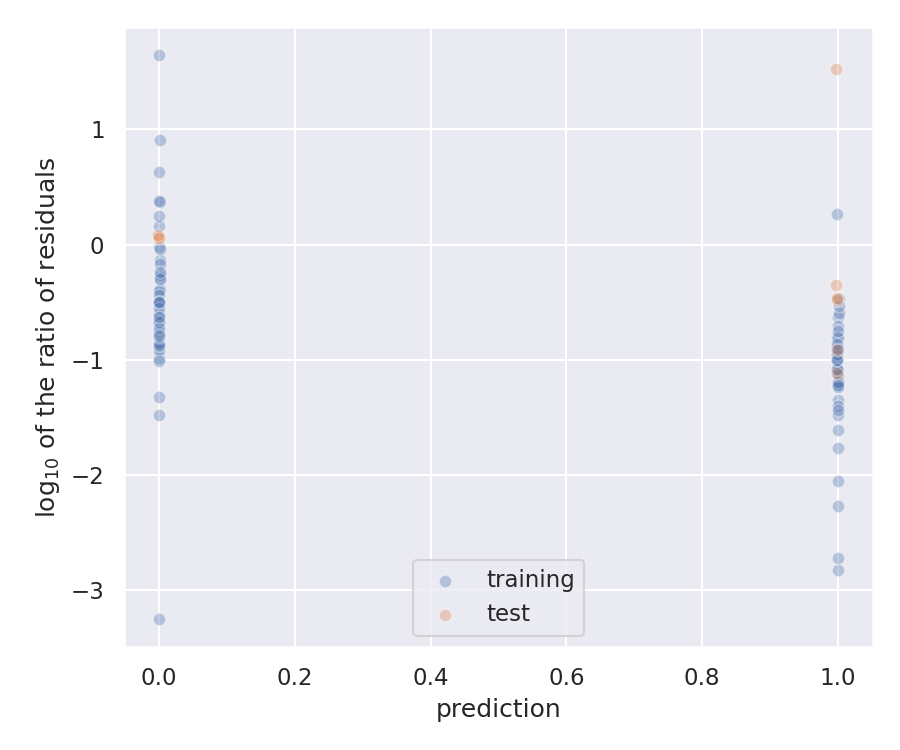

In [25]:
Image(pimg(PREFIX + 'lr_ratio_scatterplot_compare' + SUFFIX + '.png'), width=480)

### Support Vector Machine (w/ Gaussian kernel)

In [26]:
spaces    = {'gamma':   Real(1.0e-4, 1.0e1, prior='log-uniform'),
             'C':       Real(1.0e-4, 1.0e2, prior='log-uniform'),
             'epsilon': Real(1.0e-4, 1.0e-1, prior='log-uniform')
            }
estimator = BayesSearchCV(SVR(kernel='rbf', tol=1.0e-5),
                          spaces,
                          n_iter=100,
                          scoring='neg_mean_squared_error',
                          n_jobs=-1,
                          cv=cv,
                          random_state=RAND
                         )         

# fit the estimator
t = time.time()
estimator = estimator.fit(X_train, y_train)
t = time.time() - t
print(f'Optimisation time: {t:.3f} seconds.')

Optimisation time: 117.682 seconds.


In [27]:
best_estimator, cv_score, best_hyperparameters = statisticsCV(estimator, cv)
print(f'CV score: {-cv_score[0]:.3f} ± {cv_score[1]:.3f}')

CV score: 0.026 ± 0.002


In [28]:
# save best estimator
joblib.dump(best_estimator, pmod(PREFIX + 'svr' + SUFFIX + '.pkl'))

['./models/lumps_svr_type2.pkl']

In [29]:
# save the hyperparameters
best_hyperparameters.to_csv(pmet(PREFIX + 'svr_hyperparameters' + SUFFIX + '.csv'))
best_hyperparameters

,svr
C,97.091393
epsilon,0.000159
gamma,0.000498


In [30]:
train_metrics = make_predictions(best_estimator, X_train, y_train, last_train, prefix=PREFIX, suffix=SUFFIX, name='train_svr')
test_metrics  = make_predictions(best_estimator, X_test, y_test, last_test, prefix=PREFIX, suffix=SUFFIX, name='test_svr')

# concatenate the prediction results
metrics = pd.concat([train_metrics, test_metrics], axis=0).transpose()
metrics.to_csv(pmet(PREFIX + 'svr_metrics' + SUFFIX + '.csv'))
metrics

,train_svr,test_svr
mean_squared_error,0.000002,0.000004
mean_absolute_error,0.000869,0.001933
r2_score,0.999993,0.999980
residual_ratio,-0.586898,-0.029897


In [31]:
make_plots(estimator, X_train, y_train, last_train, prefix=PREFIX, suffix=SUFFIX, name='train_svr')
make_plots(estimator, X_test, y_test, last_test, prefix=PREFIX, suffix=SUFFIX, name='test_svr')
compare_plots(estimator, X_train, y_train, last_train, X_test, y_test, last_test, legend=['training', 'test'], prefix=PREFIX, suffix=SUFFIX, name='svr')

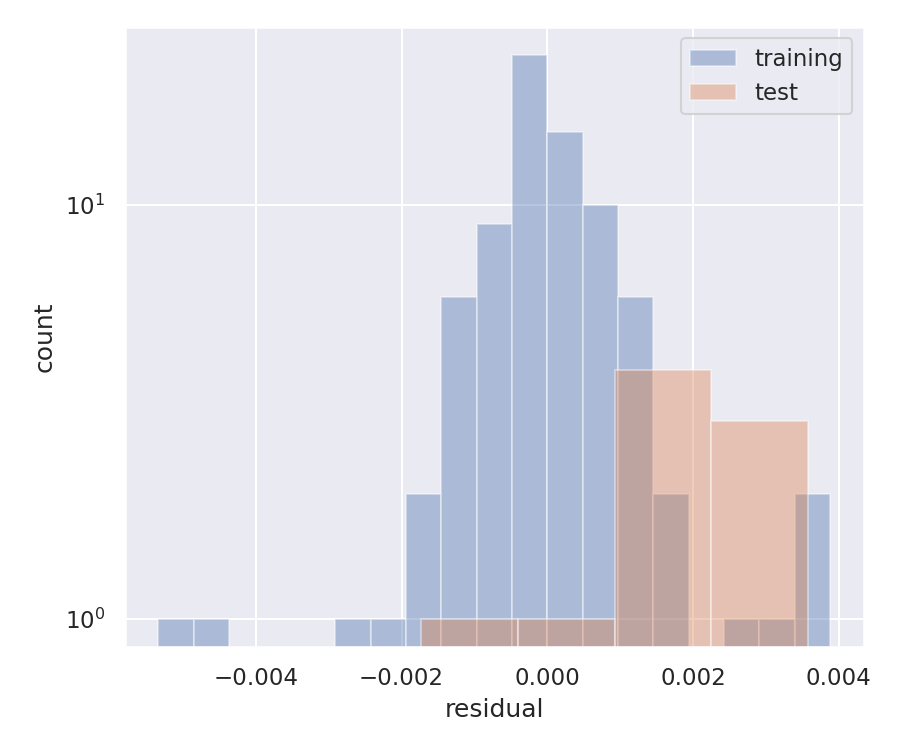

In [32]:
Image(pimg(PREFIX + 'svr_residual_histogram_compare' + SUFFIX + '.png'), width=480)

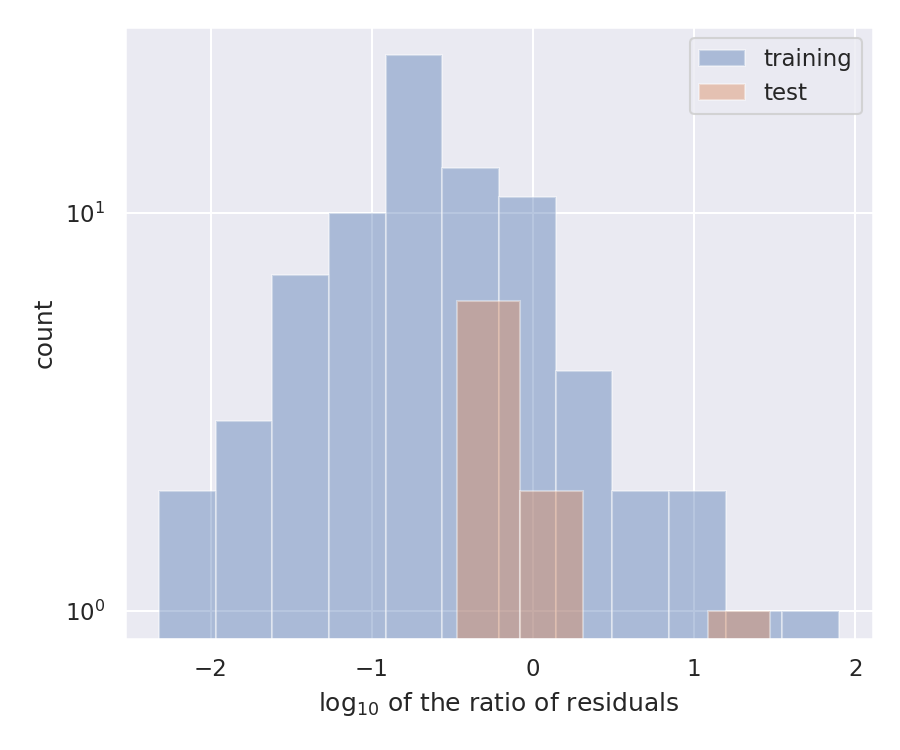

In [33]:
Image(pimg(PREFIX + 'svr_ratio_histogram_compare' + SUFFIX + '.png'), width=480)

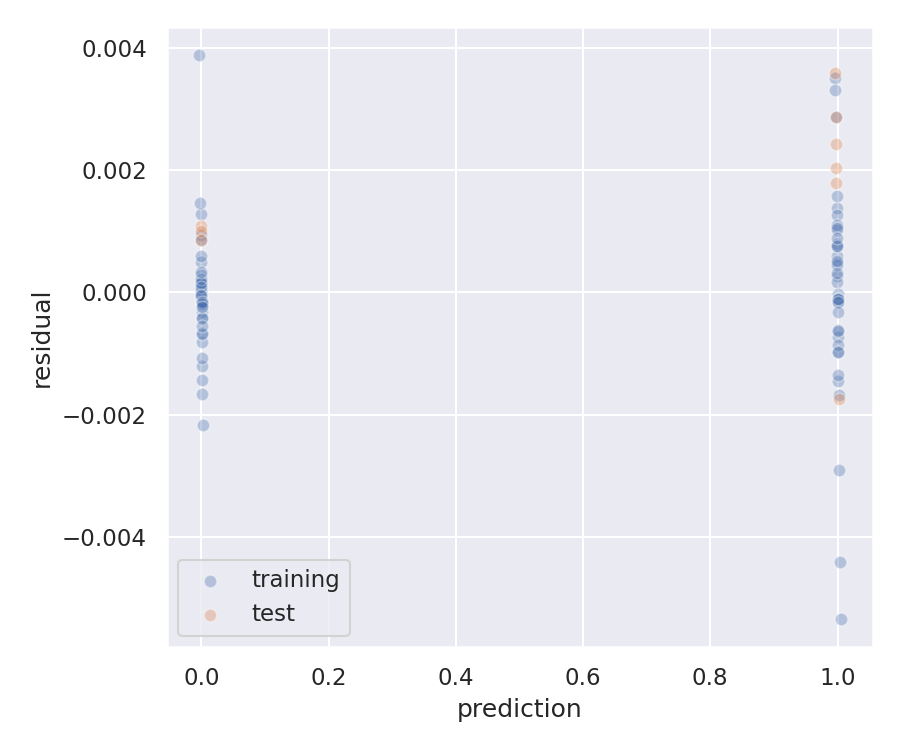

In [34]:
Image(pimg(PREFIX + 'svr_residual_scatterplot_compare' + SUFFIX + '.png'), width=480)

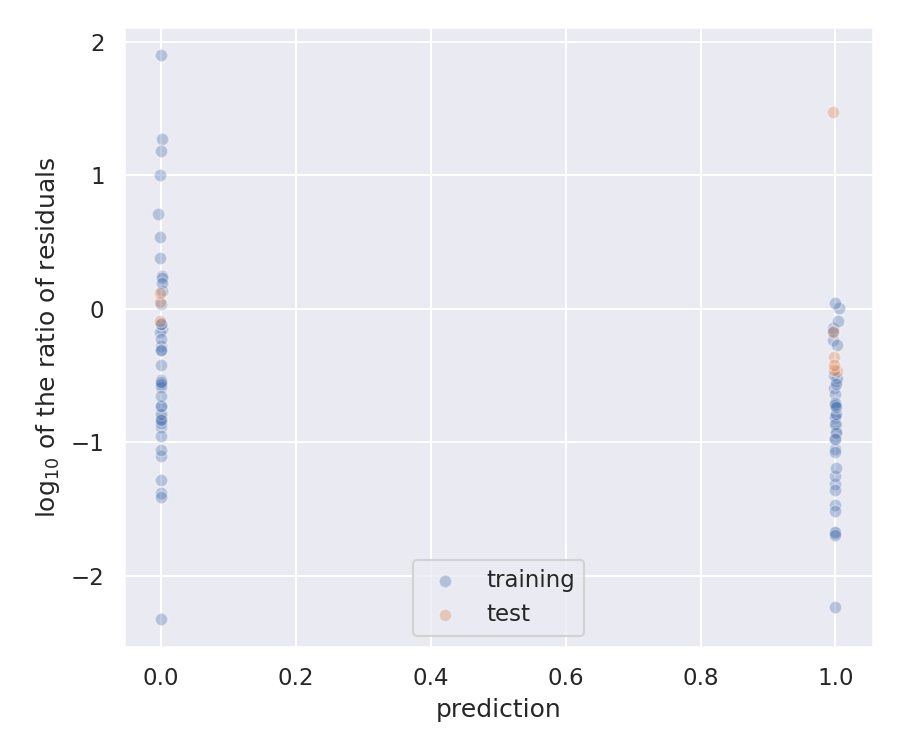

In [35]:
Image(pimg(PREFIX + 'svr_ratio_scatterplot_compare' + SUFFIX + '.png'), width=480)

### Gradient Boosted Decision Trees

In [36]:
spaces    = {'num_leaves':       Integer(2, 100),
             'max_depth':        Integer(2, 25),
             'learning_rate':    Real(1e-5, 1e-1, prior='log-uniform'),
             'n_estimators':     Integer(1e1, 1e4, prior='log-uniform'),
             'subsample':        Real(0.8, 0.9),
             'colsample_bytree': Real(0.7, 1.0),
             'min_child_weight': Real(1.0e-3, 1.0e-1, prior='log-uniform'),
             'reg_alpha':        Real(1.0e-5, 1.0e-1, prior='log-uniform'),
             'reg_lambda':       Real(1.0e-5, 1.0e-1, prior='log-uniform')
            }
estimator = BayesSearchCV(LGBMRegressor(boosting_type='gbdt',
                                        objective='regression',
                                        subsample_freq=1,
                                        n_jobs=-1,
                                        importance_type='gain'
                                       ),
                          spaces,
                          n_iter=100,
                          scoring='neg_mean_squared_error',
                          n_jobs=-1,
                          cv=cv,
                          random_state=RAND
                         )         

# fit the estimator
t = time.time()
estimator = estimator.fit(X_train, y_train)
t = time.time() - t
print(f'Optimisation time: {t:.3f} seconds.')

Optimisation time: 198.250 seconds.


In [37]:
best_estimator, cv_score, best_hyperparameters = statisticsCV(estimator, cv)
print(f'CV score: {-cv_score[0]:.3f} ± {cv_score[1]:.3f}')

CV score: 0.014 ± 0.001


In [38]:
# save best estimator
joblib.dump(best_estimator, pmod(PREFIX + 'gbdt' + SUFFIX + '.pkl'))

['./models/lumps_gbdt_type2.pkl']

In [39]:
# save the hyperparameters
best_hyperparameters.to_csv(pmet(PREFIX + 'gbdt_hyperparameters' + SUFFIX + '.csv'))
best_hyperparameters

,lgbmregressor
colsample_bytree,0.70000
learning_rate,0.10000
max_depth,2.00000
min_child_weight,0.10000
n_estimators,3676.00000
num_leaves,100.00000
reg_alpha,0.00001
reg_lambda,0.00001
subsample,0.90000


In [40]:
train_metrics = make_predictions(best_estimator, X_train, y_train, last_train, prefix=PREFIX, suffix=SUFFIX, name='train_gbdt')
test_metrics  = make_predictions(best_estimator, X_test, y_test, last_test, prefix=PREFIX, suffix=SUFFIX, name='test_gbdt')

# concatenate the prediction results
metrics = pd.concat([train_metrics, test_metrics], axis=0).transpose()
metrics.to_csv(pmet(PREFIX + 'gbdt_metrics' + SUFFIX + '.csv'))
metrics

,train_gbdt,test_gbdt
mean_squared_error,0.000014,0.002554
mean_absolute_error,0.002432,0.030419
r2_score,0.999945,0.988506
residual_ratio,-0.114711,0.795103


In [41]:
make_plots(estimator, X_train, y_train, last_train, prefix=PREFIX, suffix=SUFFIX, name='train_gbdt')
make_plots(estimator, X_test, y_test, last_test, prefix=PREFIX, suffix=SUFFIX, name='test_gbdt')
compare_plots(estimator, X_train, y_train, last_train, X_test, y_test, last_test, legend=['training', 'test'], prefix=PREFIX, suffix=SUFFIX, name='gbdt')

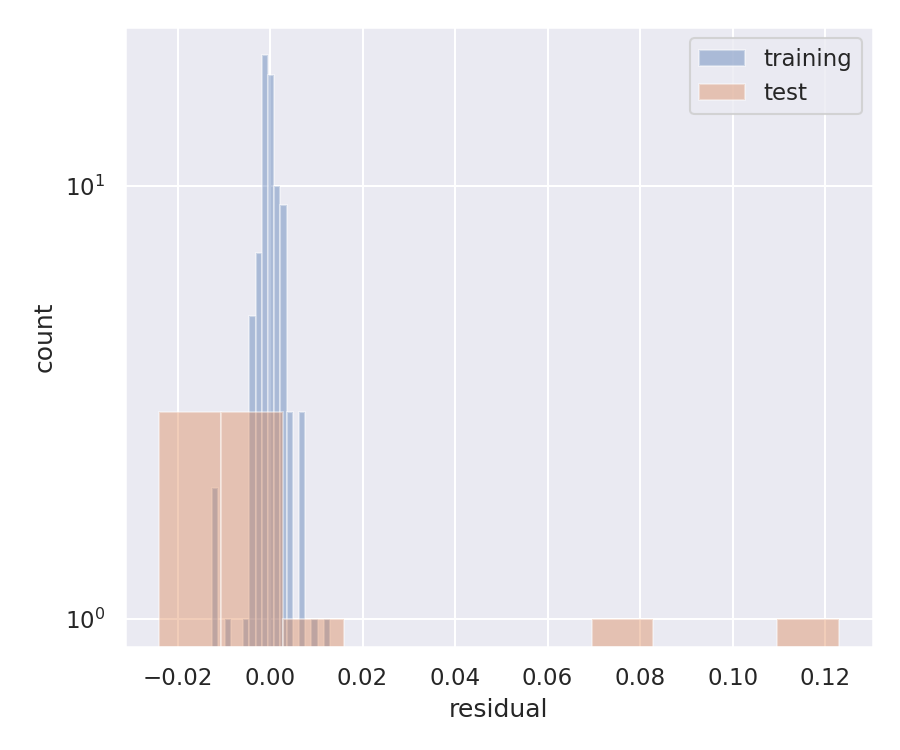

In [42]:
Image(pimg(PREFIX + 'gbdt_residual_histogram_compare' + SUFFIX + '.png'), width=480)

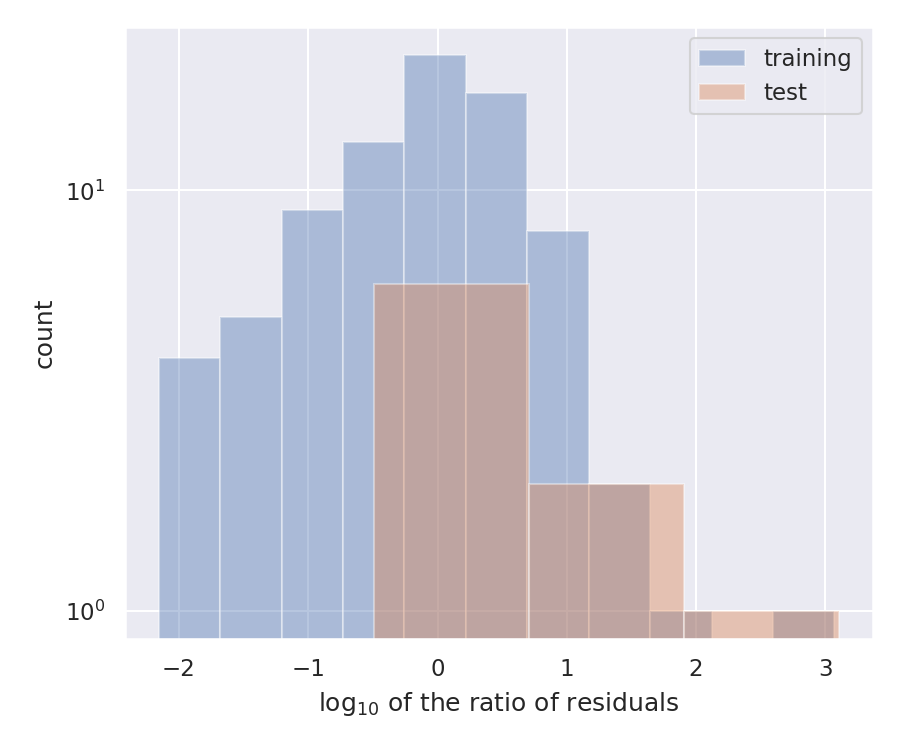

In [43]:
Image(pimg(PREFIX + 'gbdt_ratio_histogram_compare' + SUFFIX + '.png'), width=480)

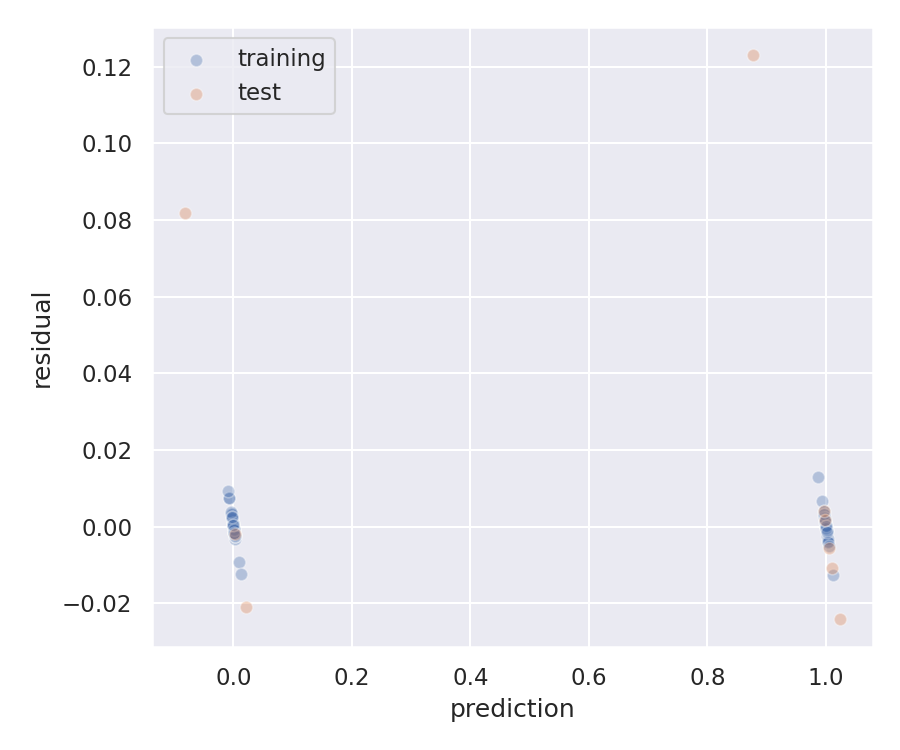

In [44]:
Image(pimg(PREFIX + 'gbdt_residual_scatterplot_compare' + SUFFIX + '.png'), width=480)

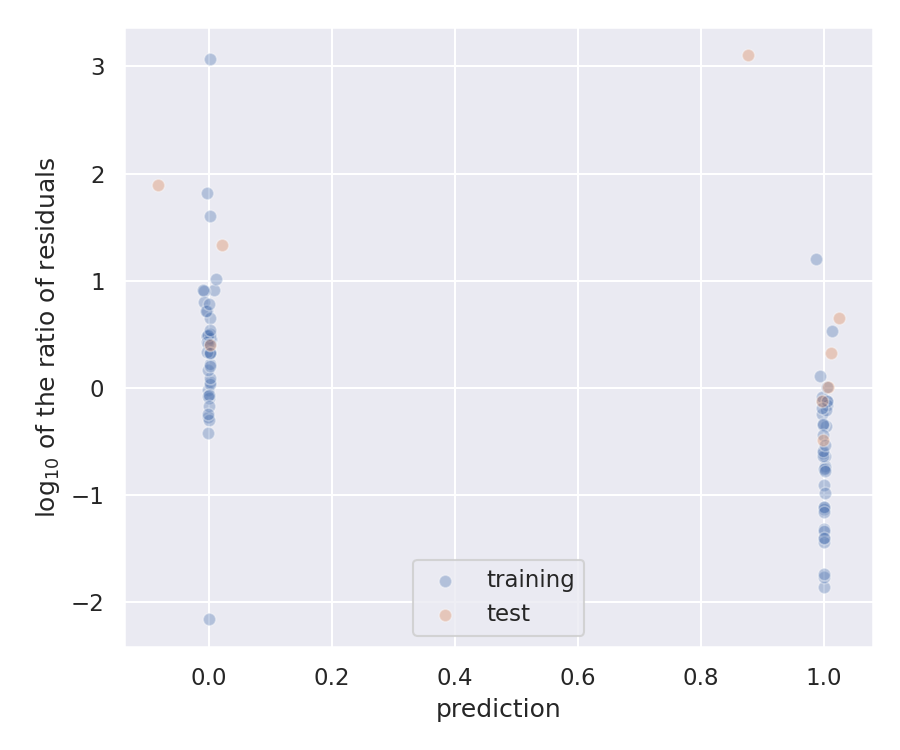

In [45]:
Image(pimg(PREFIX + 'gbdt_ratio_scatterplot_compare' + SUFFIX + '.png'), width=480)

### Artificial Neural Network (w/ Keras)

In [46]:
keras.backend.clear_session()

ann = keras.models.Sequential([keras.layers.Input(shape=X_train_nn.shape[1:], name='input'),
                               #####################################################################
                               keras.layers.Dense(50,
                                                  #kernel_regularizer=keras.regularizers.l2(1.0e-5),
                                                 ),
                               keras.layers.LeakyReLU(0.05),
                               keras.layers.Dropout(0.03),
                               #####################################################################
                               keras.layers.Dense(30,
                                                  #kernel_regularizer=keras.regularizers.l2(1.0e-5),
                                                 ),
                               keras.layers.LeakyReLU(0.05),
                               keras.layers.Dropout(0.05),
                               #####################################################################
                               keras.layers.Dense(20,
                                                  #kernel_regularizer=keras.regularizers.l2(1.0e-5),
                                                 ),
                               keras.layers.LeakyReLU(0.05),
                               keras.layers.Dropout(0.05),
                               #####################################################################
                               keras.layers.Dense(20,
                                                  #kernel_regularizer=keras.regularizers.l2(1.0e-5),
                                                 ),
                               keras.layers.LeakyReLU(0.05),
                               keras.layers.Dropout(0.05),
                               #####################################################################
                               keras.layers.Dense(10,
                                                  #kernel_regularizer=keras.regularizers.l2(1.0e-5),
                                                 ),
                               keras.layers.LeakyReLU(0.05),
                               #####################################################################
                               keras.layers.Dense(10,
                                                  #kernel_regularizer=keras.regularizers.l2(1.0e-5),
                                                 ),
                               keras.layers.LeakyReLU(0.05),
                               #####################################################################
                               keras.layers.Dense(1, name='exp')
                              ],
                              name='lumps'
                             )
ann.compile(optimizer=keras.optimizers.Adam(learning_rate=1.0e-3),
            loss=keras.losses.MeanSquaredError(),
            metrics=[keras.metrics.MeanSquaredError(), keras.metrics.MeanAbsoluteError()]
           )
ann.summary()

Model: "lumps"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                900       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 50)                0         
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1530      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 30)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                620   

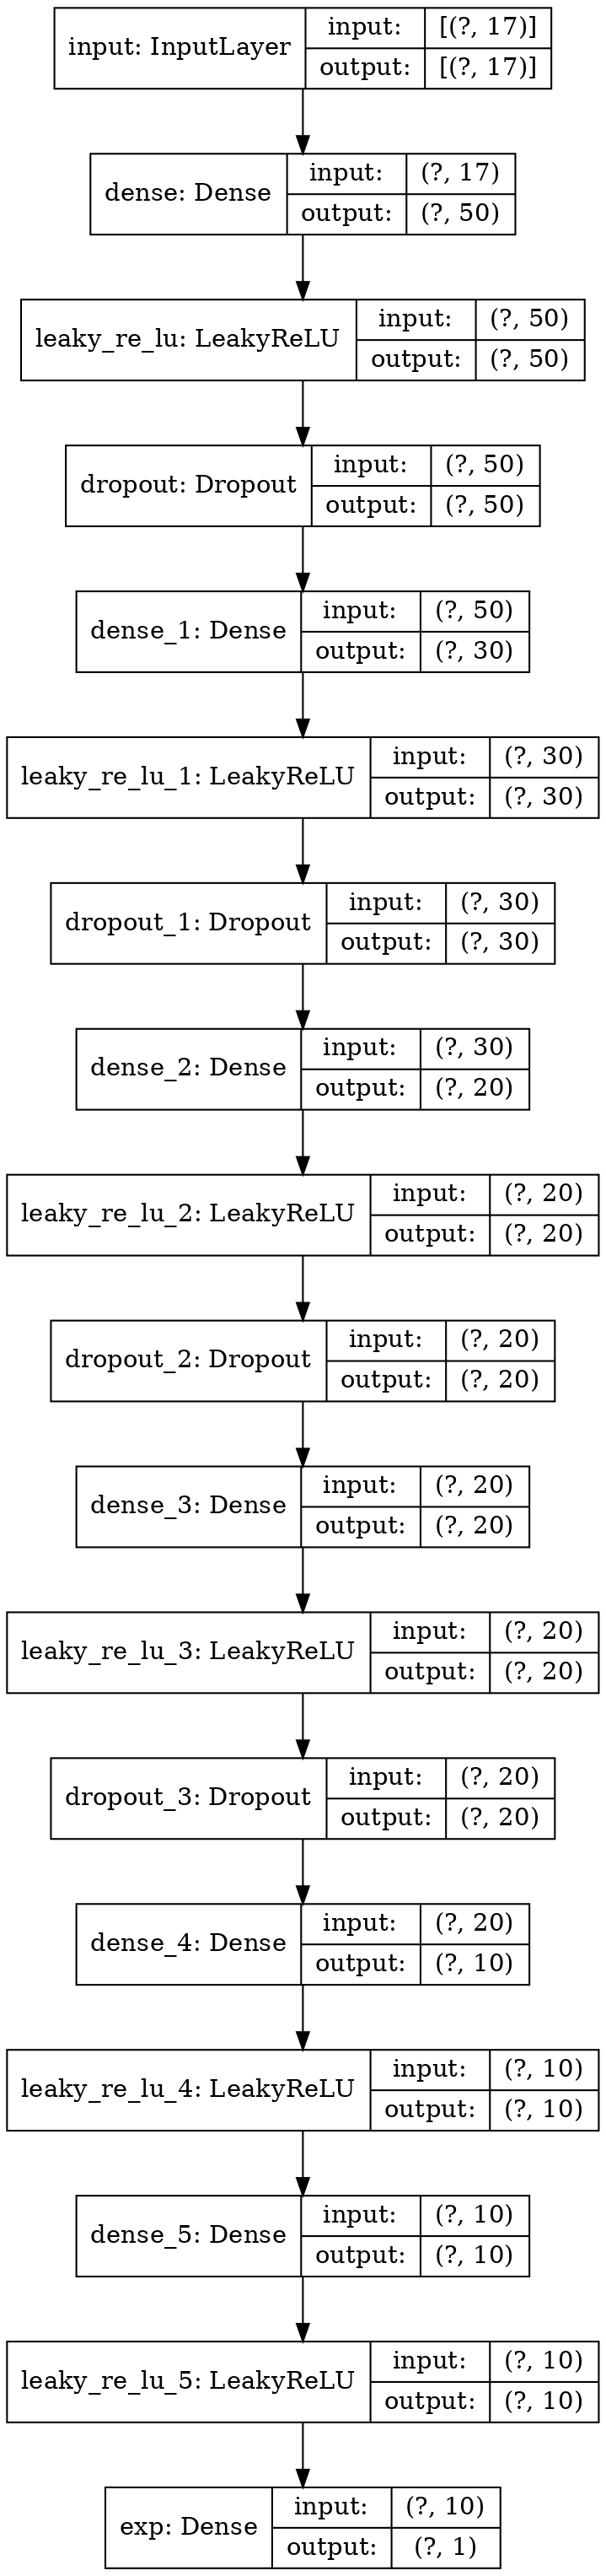

In [47]:
# save figure
ann_dot = keras.utils.model_to_dot(ann,
                                   #rankdir='LR',
                                   rankdir='TB',
                                   show_shapes=True,
                                   dpi=150)
ann_dot.write_pdf(pimg(PREFIX + 'ann_arch' + SUFFIX + '.pdf'))
Image(ann_dot.create_png(), width=320)

In [48]:
def lr_scheduler(epoch, lr):
    '''
    Schedule the learning rate:
    
    Arguments:
        epoch: the current epoch,
        lr:    the current learning rate.
    '''
    if epoch < 1000:
        return lr
    else:
        if lr <= 1.0e-6:
            return lr
        else:
            return lr * tf.math.exp(-1.0e-3)

In [49]:
t = time.time()
ann_history = ann.fit(x=X_train_nn,
                      y=y_train_nn,
                      batch_size=32,
                      epochs=20000,
                      verbose=0,
                      callbacks=[keras.callbacks.EarlyStopping(patience=2500, restore_best_weights=True, verbose=0),
                                 keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=0),
                                 keras.callbacks.ModelCheckpoint(pmod(PREFIX + 'ann' + SUFFIX + '.h5'), verbose=0, save_best_only=True)
                                ],
                      validation_data=(X_val_nn, y_val_nn)
                     )
t = time.time() - t
print(f'Training took {t:.3f} seconds.')

Training took 59.377 seconds.


In [50]:
# save and display history
ann_history_obj = pd.DataFrame(ann_history.history)
ann_history_obj.to_csv(pmod(PREFIX + 'ann_history' + SUFFIX + '.csv'), index=False)
print(f'No. of epochs: {ann_history_obj.shape[0]:d}')

No. of epochs: 2697


In [51]:
history_plots(ann_history_obj, prefix=PREFIX, suffix=SUFFIX)

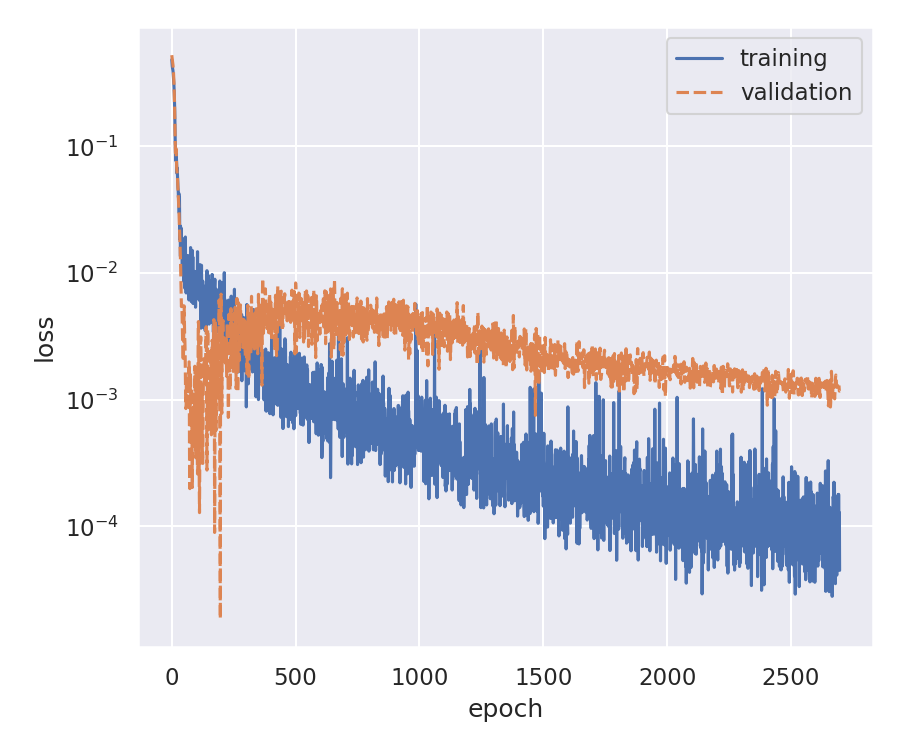

In [52]:
Image(pimg(PREFIX + 'ann_loss' + SUFFIX + '.png'), width=480)

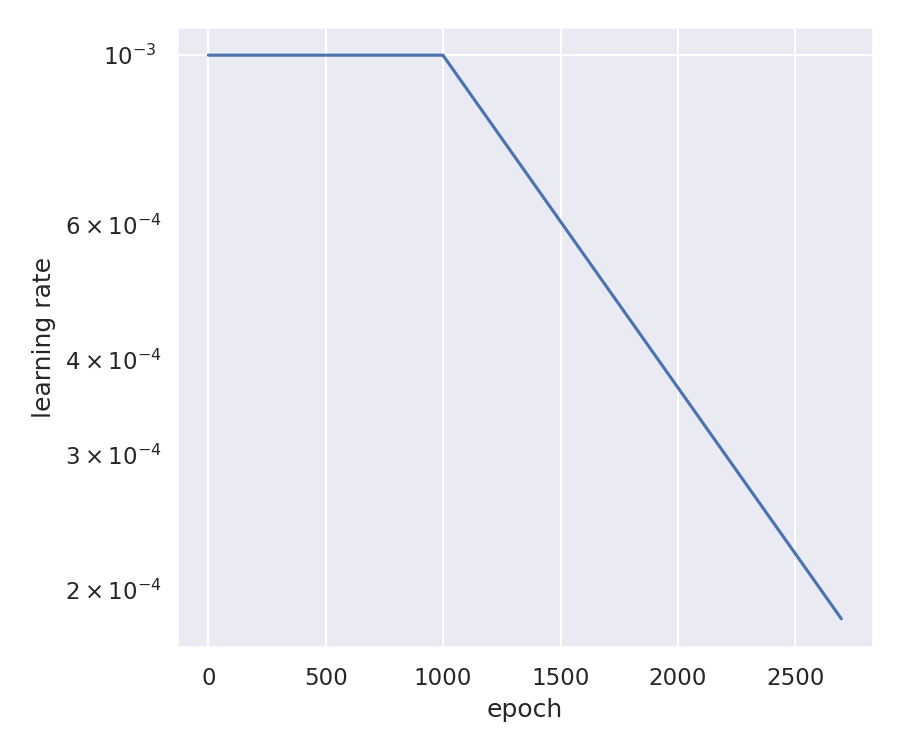

In [53]:
Image(pimg(PREFIX + 'ann_lr' + SUFFIX + '.png'), width=480)

In [54]:
train_metrics = make_predictions(ann, X_train_nn, y_train_nn, last_train_nn, prefix=PREFIX, suffix=SUFFIX, name='train_ann', tensor=True)
val_metrics   = make_predictions(ann, X_val_nn, y_val_nn, last_val_nn, prefix=PREFIX, suffix=SUFFIX, name='val_ann', tensor=True)
test_metrics  = make_predictions(ann, X_test_nn, y_test_nn, last_test_nn, prefix=PREFIX, suffix=SUFFIX, name='test_ann', tensor=True)

# concatenate the prediction results
metrics = pd.concat([train_metrics, val_metrics, test_metrics], axis=0).transpose()
metrics.to_csv(pmet(PREFIX + 'ann_metrics' + SUFFIX + '.csv'))
metrics

,train_ann,val_ann,test_ann
mean_squared_error,0.000041,0.000019,0.000390
mean_absolute_error,0.004833,0.003534,0.010314
r2_score,0.999837,0.999924,0.998244
residual_ratio,0.280211,0.207611,0.382664


In [55]:
make_plots(ann, X_train_nn, y_train_nn, last_train_nn, prefix=PREFIX, suffix=SUFFIX, name='train_ann')
make_plots(ann, X_val_nn, y_val_nn, last_val_nn, prefix=PREFIX, suffix=SUFFIX, name='val_ann')
make_plots(ann, X_test_nn, y_test_nn, last_test_nn, prefix=PREFIX, suffix=SUFFIX, name='test_ann')
compare_plots_val(ann,
                  X_train_nn, y_train_nn, last_train_nn,
                  X_val_nn, y_val_nn, last_val_nn,
                  X_test_nn, y_test_nn, last_test_nn,
                  legend=['training', 'validation', 'test'],
                  prefix=PREFIX,
                  suffix=SUFFIX,
                  name='ann'
                 )

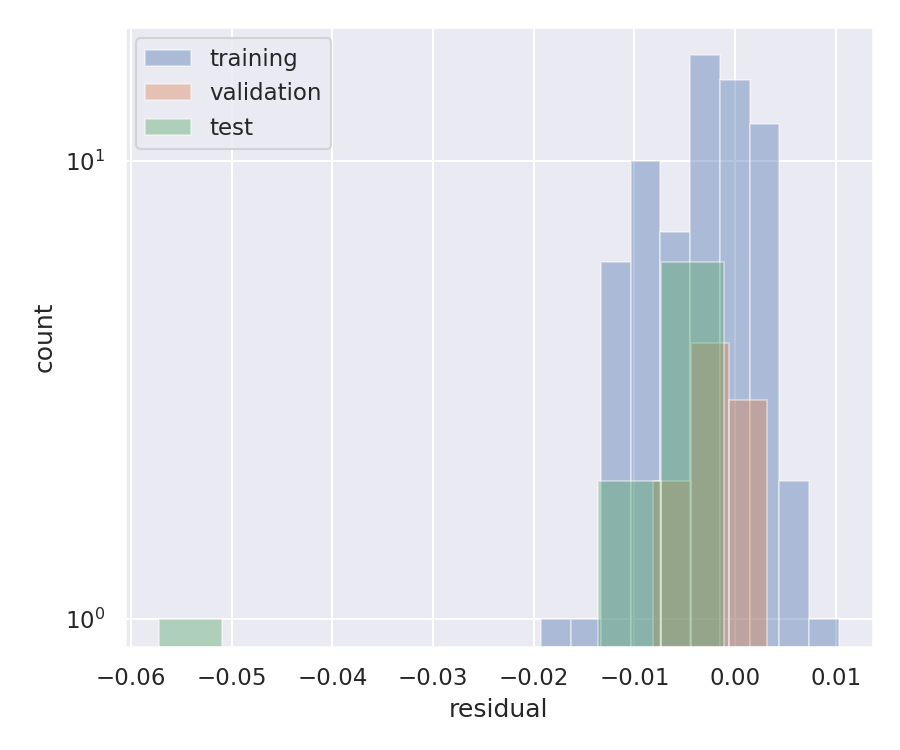

In [56]:
Image(pimg(PREFIX + 'ann_residual_histogram_compare' + SUFFIX + '.png'), width=480)

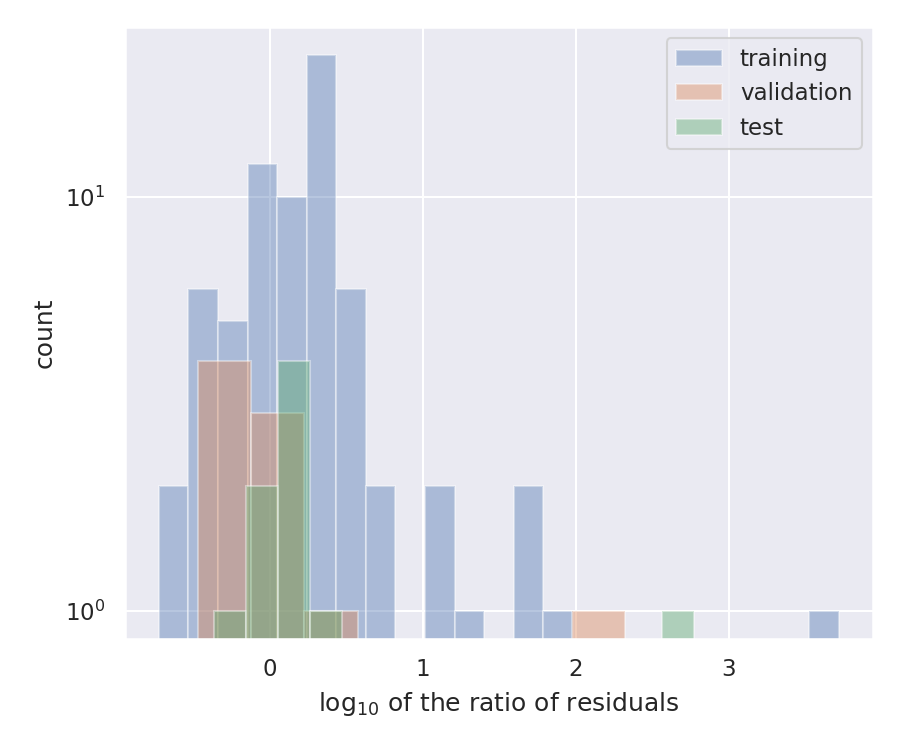

In [57]:
Image(pimg(PREFIX + 'ann_ratio_histogram_compare' + SUFFIX + '.png'), width=480)

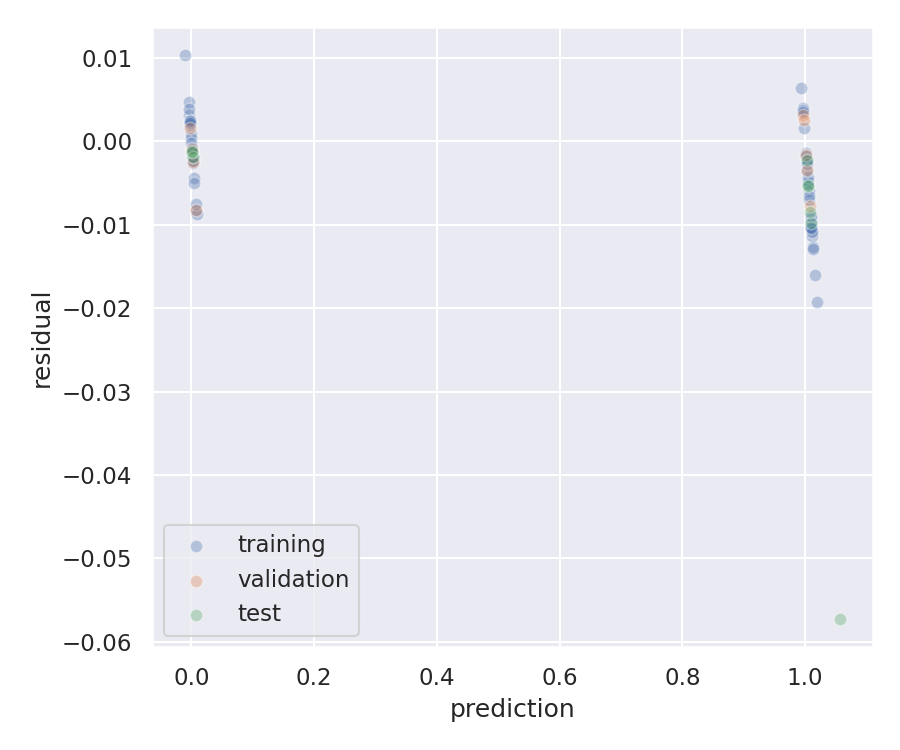

In [58]:
Image(pimg(PREFIX + 'ann_residual_scatterplot_compare' + SUFFIX + '.png'), width=480)

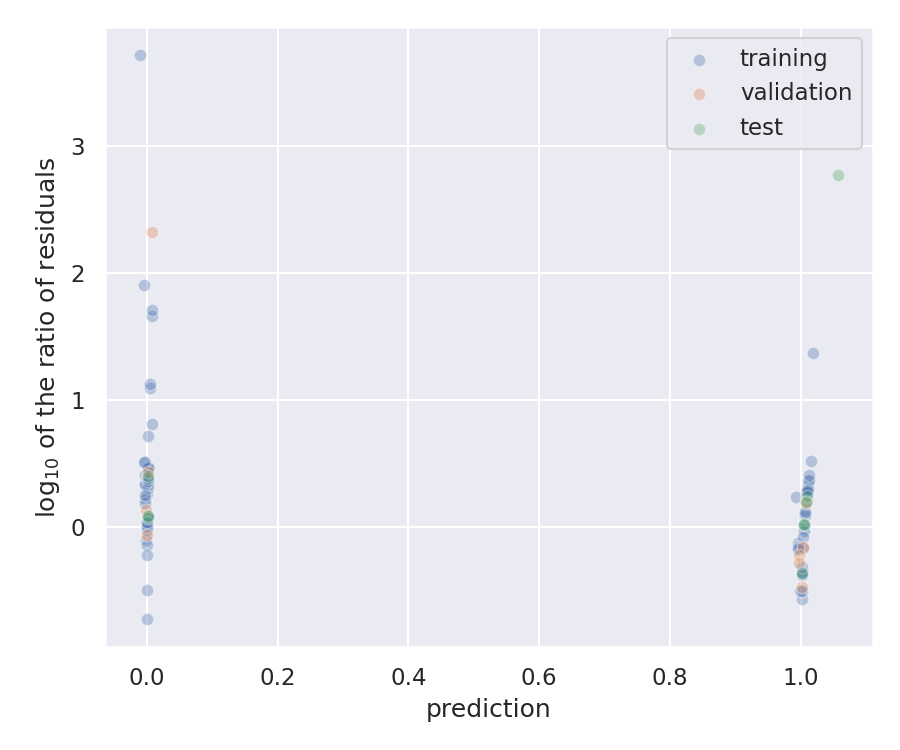

In [59]:
Image(pimg(PREFIX + 'ann_ratio_scatterplot_compare' + SUFFIX + '.png'), width=480)

## Double Lumps

We finally show how the various algorithms can generalise to double lump solutions.
We keep only weight $h \le 1.25$.

In [60]:
dlumps = pd.read_csv(pdata('dlumps.csv'))
dlumps = dlumps.loc[dlumps['weight'] <= 1.25]
dlumps = dlumps.loc[dlumps['type_2'] == 1]
dlumps = dlumps.drop(columns=['type_2', 'type_4'])
dlumps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   weight    2 non-null      float64
 1   level_2   2 non-null      float64
 2   level_3   2 non-null      float64
 3   level_4   2 non-null      float64
 4   level_5   2 non-null      float64
 5   level_6   2 non-null      float64
 6   level_7   2 non-null      float64
 7   level_8   2 non-null      float64
 8   level_9   2 non-null      float64
 9   level_10  2 non-null      float64
 10  level_11  2 non-null      float64
 11  level_12  2 non-null      float64
 12  level_13  2 non-null      float64
 13  level_14  2 non-null      float64
 14  level_15  2 non-null      float64
 15  level_16  2 non-null      float64
 16  level_17  2 non-null      float64
 17  level_18  2 non-null      float64
 18  exp       2 non-null      float64
dtypes: float64(19)
memory usage: 320.0 bytes


# Extract the Labels

In [61]:
# extract the labels
y_dlumps    = dlumps['exp'].values.reshape(-1,)
y_dlumps_nn = dlumps['exp'].values.reshape(-1,)

## Apply Fourier Transform to the Levels

In [62]:
# extract the features
X_dlumps = dlumps.drop(columns=['exp']).values

# compute Fourier transform (for real input)
levels = np.fft.rfft(X_dlumps[:,3:], axis=1)

# separate modulus and argument
levels_mod = np.abs(levels)
levels_ang = np.angle(levels) / np.pi

# concatenate the arrays (the first imaginary part is identically vanishing)
levels_conc = np.c_[levels_mod[:,1:], levels_ang[:,1:]]

# join the output
X_dlumps = np.c_[X_dlumps[:,:3], levels_conc]

## Rescale the Features

In [63]:
lev_scaler    = joblib.load(pmod(PREFIX + 'levels_cv_scaler' + SUFFIX + '.pkl'))
lev_scaler_nn = joblib.load(pmod(PREFIX + 'levels_cv_scaler' + SUFFIX + '.pkl'))

# rescale the levels
X_dlumps_nn       = X_dlumps
X_dlumps[:,3:]    = lev_scaler.transform(X_dlumps[:,3:])
X_dlumps_nn[:,3:] = lev_scaler_nn.transform(X_dlumps_nn[:,3:])

## Compute Predictions

In [64]:
predictions = {'real_values': dlumps['exp'].values.reshape(-1,),
               'finite_values': dlumps['level_18'].values.reshape(-1,)
              }

# linear regression
linear = joblib.load(pmod(PREFIX + 'lr' + SUFFIX + '.pkl'))
predictions['linear_regression'] = 2 * linear.predict(X_dlumps).reshape(-1,1).reshape(-1,)

# SVR
svr = joblib.load(pmod(PREFIX + 'svr' + SUFFIX + '.pkl'))
predictions['svr'] = 2 * svr.predict(X_dlumps).reshape(-1,1).reshape(-1,)

# GBDT
gbdt = joblib.load(pmod(PREFIX + 'gbdt' + SUFFIX + '.pkl'))
predictions['gbdt'] = 2 * gbdt.predict(X_dlumps).reshape(-1,1).reshape(-1,)

# ANN
ann = keras.models.load_model(pmod(PREFIX + 'ann' + SUFFIX + '.h5'))
predictions['neural_network'] = 2 * ann.predict(X_dlumps_nn).reshape(-1,1).reshape(-1,)

# get dataframe
predictions = pd.DataFrame(predictions)
predictions.to_csv(pdata(PREFIX + 'dlumps_predictions' + SUFFIX + '.csv'), index=False)
predictions

,real_values,finite_values,linear_regression,svr,gbdt,neural_network
0,2.000132,2.010872,-12.671578,0.252963,1.999264,128.183502
1,-0.000045,0.000039,8.879275,0.252963,0.006636,-1.455972


In [65]:
algorithms = ['linear_regression', 'svr', 'gbdt', 'neural_network']

metrics = {'mean_squared_error': [mean_squared_error(predictions['real_values'],
                                                     predictions[f]
                                                    ) for f in algorithms
                                 ],
           'mean_absolute_error': [mean_absolute_error(predictions['real_values'],
                                                       predictions[f]
                                                      ) for f in algorithms
                                  ],
           'r2_score': [r2_score(predictions['real_values'],
                                 predictions[f]
                                ) for f in algorithms
                       ],
           'residual_ratio': [metric(predictions['real_values'],
                                     dlumps['level_18'].values.reshape(-1,),
                                     predictions[f]
                                    ) for f in algorithms
                             ]
          }

# get dataframe
metrics = pd.DataFrame(metrics, index=algorithms)
metrics.to_csv(pmet(PREFIX + 'dlumps_metrics' + SUFFIX + '.csv'))
metrics

,mean_squared_error,mean_absolute_error,r2_score,residual_ratio
linear_regression,147.050686,11.775515,-146.024755,4.108028
svr,1.558305,1.000088,-0.558030,2.873332
gbdt,0.000023,0.003775,0.999977,0.432284
neural_network,7962.181367,63.819649,-7959.777345,4.182669


In [66]:
# compute residual and residual ratio per value
residuals = {f + '_res': predictions['real_values'].values.reshape(-1,) - predictions[f].values.reshape(-1,) for f in algorithms}
ratios    = {f + '_ratio': np.log10(
                                np.abs(
                                np.divide(predictions['real_values'].values.reshape(-1,) - predictions[f].values.reshape(-1,),
                                          predictions['real_values'].values.reshape(-1,) - predictions['finite_values'].values.reshape(-1,)
                                         )
                                )
                            ) for  f in algorithms
            }

# get dataframe
residuals = pd.DataFrame(residuals)
ratios    = pd.DataFrame(ratios)
metric_per_value = pd.concat([residuals, ratios], axis=1)
metric_per_value.to_csv(pmet(PREFIX + 'dlumps_metric_per_value' + SUFFIX + '.csv'), index=False)
metric_per_value

,linear_regression_res,svr_res,gbdt_res,neural_network_res,linear_regression_ratio,svr_ratio,gbdt_ratio,neural_network_ratio
0,14.671709,1.747168,0.000868,-126.183371,3.135480,2.211334,-1.092482,4.070001
1,-8.879320,-0.253008,-0.006681,1.455927,5.025002,3.479757,1.901476,4.239762
